In [40]:
from option_class import Option


S = 100
K = 100
r = 0.05
T = 1
sigma = 0.2
option_type = 'call' 

option = Option(S, K, T, r, sigma, option_type)

true_price = option.black_scholes()
mc_price, _ = option.monte_carlo(num_paths=1000, num_steps=100)
antithetic_price, _ = option.antithetic_monte_carlo(num_paths=1000, num_steps=100)

print('True price: ', true_price)
print('MC price: ', mc_price)
print('Antithetic MC price: ', antithetic_price)

True price:  10.450583572185565
MC price:  9.465998372113056
Antithetic MC price:  10.516590213859356


In [41]:
from utils import Comparison


comparison = Comparison()

results = comparison.methods_comparison(option, num_paths=1000, num_steps=100)

results

,Black-Scholes,Monte Carlo,Antithetic Monte Carlo,Binomial Tree,Trinomial Tree
Price,10.450584,11.076686,10.013224,10.430612,13.214355
Time,0.000000,0.084082,0.117470,0.006625,0.000285


<Axes: ylabel='Price'>

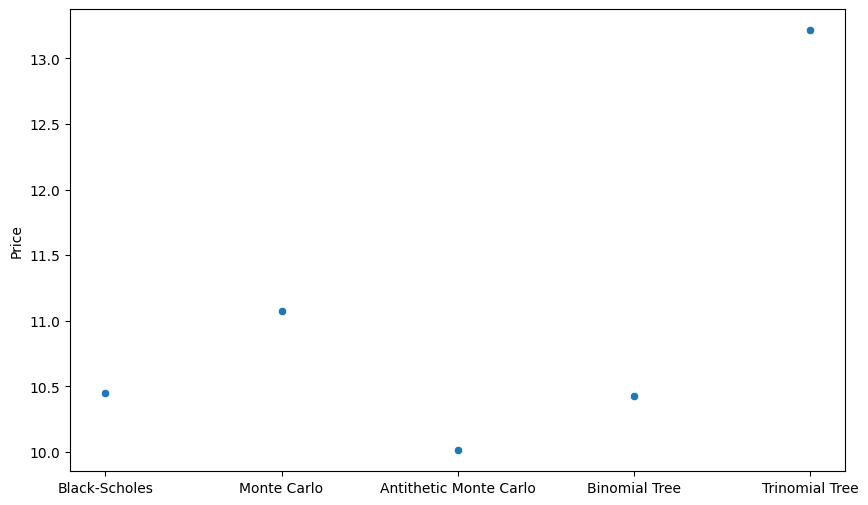

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(results.loc['Price'])

In [43]:
from pricing.greeks_calc import GREEKS

greek = GREEKS(S, K, r, T, sigma, option_type)
greeks = greek.calculate_greeks()

greeks

,Delta,Gamma,Vega,Theta,Rho
Value,0.872939,0.046558,4.655808,-84.409459,4.106406


In [44]:
from implied_volatility import implied_volatility

iv = implied_volatility(option, 10.37)

iv

0.1978518673668909

In [ ]:
from option_class import Option
import time
import pandas as pd
import numpy as np
from multiprocessing import Pool


def calculate_monte_carlo_price(args):
    # Now only unpack 7 values from args
    S, K, T, r, sigma, num_paths, num_steps, option_type = args
    option = Option(S, K, T, r, sigma, option_type)
    true_price = option.black_scholes()
    mc_price, _ = option.monte_carlo(num_paths, num_steps)
    return mc_price, abs(mc_price - true_price)

def calculate_binomial_tree_price(args):
    S, K, T, r, sigma, num_steps, option_type = args
    option = Option(S, K, T, r, sigma, option_type)
    true_price = option.black_scholes()
    bt_price = option.binomial_tree(num_steps)
    return bt_price, abs(bt_price - true_price)

def calculate_trinomial_tree_price(args):
    S, K, T, r, sigma, num_steps, option_type = args
    option = Option(S, K, T, r, sigma, option_type)
    true_price = option.black_scholes()
    tt_price = option.trinomial_tree(num_steps)
    return tt_price, abs(tt_price - true_price)



class Comparison:
  
    def __init__(self):
        pass
        
    def methods_comparison(self, option, num_paths, num_steps):
    
        """
        Compare the prices and times of the Black-Scholes, Monte Carlo, Binomial Tree, and Trinomial Tree methods for European options.

        Parameters:
        S : float
            Current stock price.
        K : float
            Option strike price.
        T : float
            Time to expiration in years.
        r : float
            Risk-free interest rate.
        sigma : float
            Volatility of the stock.
        num_paths : int
            Number of Monte Carlo paths to simulate.
        num_steps : int
            Number of time steps for each path.
        option_type : str, optional
            Type of the option, either 'call' or 'put'. Default is 'call'.

        Returns:
        tuple
            A DataFrame containing the option prices and respective times for the Black-Scholes, Monte Carlo, Binomial Tree, and Trinomial Tree methods.
        """
        
        start = time.time()
        bs_price = option.black_scholes()
        bs_time = time.time() - start
        
        start = time.time()
        mc_price, _ = option.monte_carlo(num_paths, num_steps)
        mc_time = time.time() - start
        
        start = time.time()
        antithetic_price, _ = option.antithetic_monte_carlo(num_paths, num_steps)
        antithetic_time = time.time() - start
        
        start = time.time()
        bt_price = option.binomial_tree(num_steps)
        bt_time = time.time() - start
        
        start = time.time()
        tt_price = option.trinomial_tree(num_steps)
        tt_time = time.time() - start
        
        results = pd.DataFrame({'Black-Scholes': [bs_price, bs_time],
                                'Monte Carlo': [mc_price, mc_time],
                                'Antithetic Monte Carlo': [antithetic_price, antithetic_time],
                                'Binomial Tree': [bt_price, bt_time],
                                'Trinomial Tree': [tt_price, tt_time]},
                            index=['Price', 'Time'])
        
        return results

    def convergence_speed(self, option, num_paths, num_steps):
        """
        Calculate the prices of European options using the Monte Carlo, Binomial Tree, and Trinomial Tree methods and
        their respective errors compared to the Black-Scholes price.

        Parameters:
        option : Option
            The option for which to calculate the prices.
        num_paths : int
            Number of paths for each Monte Carlo simulation.
        num_steps : int
            Number of time steps for each Binomial and Trinomial Tree simulation.

        Returns:
        tuple
            A tuple containing two DataFrames: results and error. The results DataFrame contains the prices of the
            option calculated using the Monte Carlo, Binomial Tree, and Trinomial Tree methods. The error DataFrame
            contains the errors of the respective methods compared to the Black-Scholes price.
        """
        results = pd.DataFrame(columns=['mc_price', 'bt_price', 'tt_price'],
                            index=range(1, num_steps + 1))

        error = pd.DataFrame(columns=['mc_error', 'bt_error', 'tt_error'],
                            index=range(1, num_steps + 1))

        steps = np.arange(1, num_steps + 1)

        with Pool() as pool:
            S, K, T, r, sigma, option_type = option.S, option.K, option.T, option.r, option.sigma, option.option_type

            mc_args = [(S, K, T, r, sigma, num_paths, step, option_type) for step in steps]
            mc_results = pool.map(calculate_monte_carlo_price, mc_args)
            results['mc_price'] = [res[0] for res in mc_results]
            error['mc_error'] = [res[1] for res in mc_results]

            bt_args = [(S, K, T, r, sigma, step, option_type) for step in steps]
            bt_results = pool.map(calculate_binomial_tree_price, bt_args)
            results['bt_price'] = [res[0] for res in bt_results]
            error['bt_error'] = [res[1] for res in bt_results]

            tt_args = [(S, K, T, r, sigma, step, option_type) for step in steps]
            tt_results = pool.map(calculate_trinomial_tree_price, tt_args)
            results['tt_price'] = [res[0] for res in tt_results]
            error['tt_error'] = [res[1] for res in tt_results]

        return results, error


if __name__ == '__main__':
    option = Option(100, 100, 1, 0.05, 0.2, 'call')
    results, error = Comparison().convergence_speed(option, num_paths=1000, num_steps=100)
    print(results)

In [12]:
import yfinance as yf

ticker = 'AAPL'

underlying_price = yf.Ticker(ticker).history(period='1d')['Close'][0]

underlying_price

C:\Users\wassim\AppData\Local\Temp\ipykernel_8080\140498871.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  underlying_price = yf.Ticker(ticker).history(period='1d')['Close'][0]


222.77999877929688

In [34]:
def fetch_ticker_data(ticker, strike_price, option_type):
    
    stock = yf.Ticker(ticker)
    underlying_price = stock.history(period='1d')['Close'][0]
    option_chain = stock.option_chain()
    if option_type == 'call':
        call_option = option_chain.calls[option_chain.calls['strike'] == strike_price]
        option_price = call_option['lastPrice'].iloc[0]
        
    else:
        put_option = option_chain.puts[option_chain.puts['strike'] == strike_price]
        option_price = put_option['lastPrice'].iloc[0]
        
    return underlying_price, option_price

underlying_price, option_price = fetch_ticker_data('AAPL', 230, 'call')

C:\Users\wassim\AppData\Local\Temp\ipykernel_8080\2738523388.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  underlying_price = stock.history(period='1d')['Close'][0]


In [35]:
print(underlying_price, 'option_price: ', option_price)

238.34500122070312 option_price:  9.25


In [44]:
import yfinance as yf

ticker = 'AAPL'

price = yf.download(ticker, period='1d').iloc[-1]['Close']

price

[*********************100%***********************]  1 of 1 completed


239.1699981689453

In [63]:
from datetime import datetime, timedelta
import yfinance as yf

def fetch_option_price_and_closest_date(ticker, years_to_maturity, strike_price, option_type):
    """
    Fetch the closest expiration date and the option price for the given ticker.

    Args:
    ticker (str): Ticker symbol (e.g., "AAPL").
    years_to_maturity (int or float): Time to maturity in years.
    strike_price (float): Strike price of the option.
    option_type (str): "call" or "put".

    Returns:
    tuple: Underlying price (S), closest expiration date (str), option price (float).
    """
    # Step 1: Calculate target expiration date
    today = datetime.now()
    target_date = today + timedelta(days=int(365 * years_to_maturity))

    # Step 2: Fetch available expiration dates and find the closest one
    stock = yf.Ticker(ticker)
    available_expirations = stock.options

    if not available_expirations:
        raise ValueError(f"No options available for ticker {ticker}")

    # Convert expiration dates to datetime and find the closest
    available_dates = [datetime.strptime(date, "%Y-%m-%d") for date in available_expirations]
    closest_date = min(available_dates, key=lambda x: abs(x - target_date))
    closest_expiration_date = closest_date.strftime("%Y-%m-%d")

    # Step 3: Fetch option chain for the closest expiration date
    option_chain = stock.option_chain(closest_expiration_date)

    # Step 4: Extract the option price based on the strike price and option type
    if option_type.lower() == "call":
        options = option_chain.calls
    elif option_type.lower() == "put":
        options = option_chain.puts
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    # Find the row corresponding to the given strike price
    option_row = options[options['strike'] == strike_price]
    if option_row.empty:
        raise ValueError(f"No option found with strike price {strike_price} for expiration {closest_expiration_date}")

    # Extract the option price and underlying stock price
    option_price = option_row['lastPrice'].values[0]
    underlying_price = stock.history(period="1d")['Close'].iloc[-1]

    return underlying_price, closest_expiration_date, option_price


underlying_price, closest_expiration_date, option_price = fetch_option_price_and_closest_date('AAPL', 1, 230, 'call')

print(underlying_price, closest_expiration_date, option_price)

239.05799865722656 2026-01-16 32.5


In [53]:
option_chain = yf.Ticker('AAPL').option_chain()
option_chain.calls[option_chain.calls['strike']==230]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
32,AAPL250131C00230000,2025-01-28 15:47:36+00:00,230.0,11.0,10.75,10.75,5.6,104.6729,17075.0,20428,0.504644,True,REGULAR,USD


In [57]:
closest_expiration_date

'2026-01-16'

In [61]:
data = yf.Ticker('AAPL').option_chain(closest_expiration_date).calls

df = data[data['strike'] == 230]
df

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
44,AAPL260116C00230000,2025-01-28 15:47:11+00:00,230.0,32.26,32.1,32.45,6.259998,24.076916,192.0,9016,0.299735,True,REGULAR,USD


In [65]:
exp_date = datetime.now() + timedelta(days=int(365 * 1))

exp_date = exp_date.strftime('%Y-%m-%d')

In [66]:
exp_date

'2026-01-28'

European Call Option Price (MCMC): 173.2372


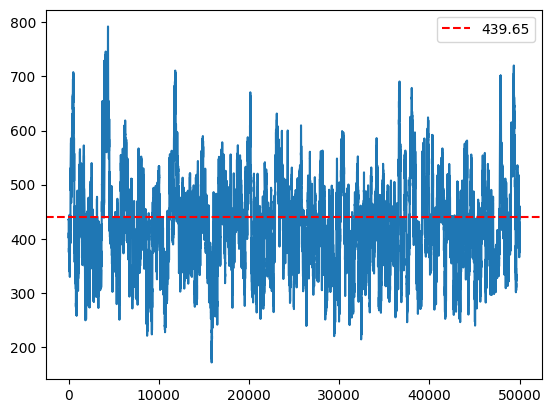

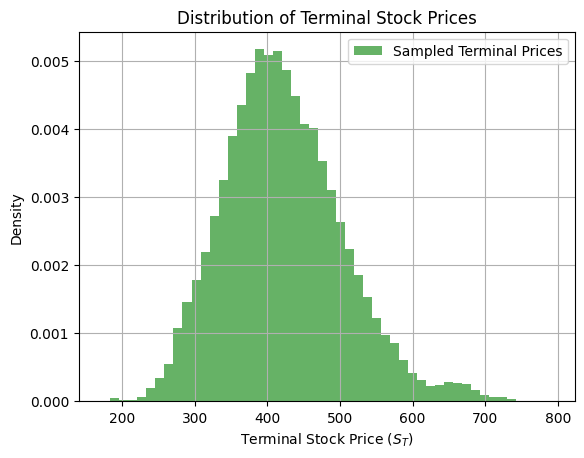

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 398.09  # Initial stock price
K = 240  # Strike price
T = 1     # Time to maturity (1 year)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
n_samples = 50000  # Number of MCMC samples

# Target distribution: Log-normal risk-neutral terminal price distribution
def target_distribution(S_T):
    mean = np.log(S0) + (r - 0.5 * sigma**2) * T
    std_dev = sigma * np.sqrt(T)
    return np.exp(- (np.log(S_T) - mean) ** 2 / (2 * std_dev ** 2)) / (S_T * std_dev * np.sqrt(2 * np.pi))

# MCMC Sampling for terminal prices
S_T_samples = []
S_T_current = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.normal())  # Initialize

# Proposal distribution standard deviation (tuning parameter)
proposal_std = 10.0  # Adjust this to control the step size

for _ in range(n_samples):
    # Propose new terminal price
    S_T_new = S_T_current + proposal_std * np.random.normal()
    
    # Ensure S_T_new is positive (since stock prices cannot be negative)
    if S_T_new <= 0:
        S_T_samples.append(S_T_current)
        continue
    
    # Acceptance ratio
    acceptance_ratio = min(1, target_distribution(S_T_new) / target_distribution(S_T_current))
    
    if np.random.rand() < acceptance_ratio:
        S_T_current = S_T_new  # Accept move
    
    S_T_samples.append(S_T_current)

# Convert to array
S_T_samples = np.array(S_T_samples)

# Compute option price using terminal prices
payoffs = np.maximum(S_T_samples - K, 0)
option_price = np.exp(-r * T) * np.mean(payoffs)

print(f"European Call Option Price (MCMC): {option_price:.4f}")


plt.plot(S_T_samples)
plt.axhline(y=S_T_samples[-1], color='r', linestyle='--', label=f"{S_T_samples[-1]:.2f}")
plt.legend(loc='best')
plt.show()
# Plot histogram of terminal prices
plt.hist(S_T_samples, bins=50, density=True, alpha=0.6, color='g', label="Sampled Terminal Prices")
plt.xlabel("Terminal Stock Price ($S_T$)")
plt.ylabel("Density")
plt.title("Distribution of Terminal Stock Prices")
plt.grid(True)
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

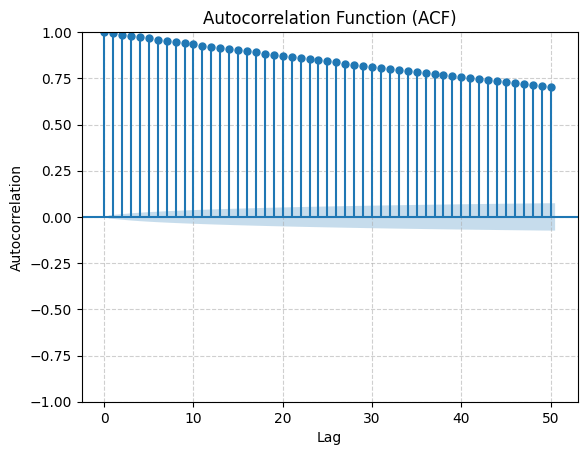

<Figure size 1200x600 with 0 Axes>

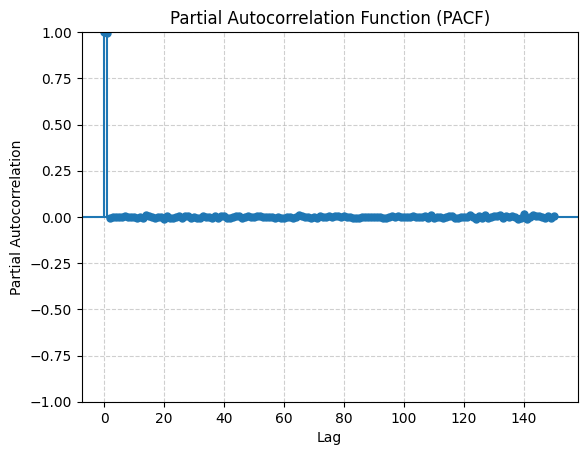

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example: Simulated MCMC samples (replace this with your actual MCMC output)

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(S_T_samples, lags=50, title="Autocorrelation Function (ACF)", zero=True, alpha=0.05)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True, linestyle='--', alpha=0.6)

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(S_T_samples, lags=150, title="Partial Autocorrelation Function (PACF)", zero=True, alpha=0.05)
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.grid(True, linestyle='--', alpha=0.6)

# Show plots
plt.show()

In [ ]:
import numpy as np

def control_variates_monte_carlo(self, num_paths, num_steps):
    
    """
    Calculate the price of European options using the Monte Carlo method with control variates.

    Parameters:
    num_paths : int
        Number of Monte Carlo paths to simulate.
    num_steps : int
        Number of time steps for each path.

    Returns:
    tuple
        A tuple containing the option price and a 2D numpy array of generated paths.
    """

    dt = self.T / num_steps
    paths = np.zeros((num_paths, num_steps+1))
    paths[:, 0] = self.S
    
    for i in range(num_paths):
      for j in range(1, num_steps+1):
        Z = np.random.normal()
        paths[i, j] = paths[i, j-1] * np.exp((self.r - 0.5 * self.sigma**2) * dt + self.sigma * sqrt(dt) * Z)
        
    if self.option_type == 'call':
      payoff = np.maximum(paths[:, -1] - self.K, 0)
    else:
      payoff = np.maximum(self.K - paths[:, -1], 0)
    
    price = np.exp(-self.r * self.T) * np.mean(payoff)
    
    cov_Y_MC = np.cov(price, paths[:, -1])[0, 1] # Covariance between discounted payoff and terminal asset price
    var_MC = np.var(paths[:, -1]) # Variance of terminal asset price
    lambda_star = cov_Y_MC / var_MC # Optimal lambda for control variates
    control_variates_adjustment = price - lambda_star * (paths[:, -1] - np.mean(paths[:, -1])) # Adjusted price using control variates
    
    MC_control_variates_price = np.exp(-self.r * self.T) * np.mean(control_variates_adjustment)
    
    return MC_control_variates_price, paths

price, paths = control_variates_monte_carlo

In [84]:
import numpy as np
from math import sqrt

def euler_maruyama(S, K, T, r, sigma, num_paths, num_steps, option_type='call'):
    
    dt = T / num_steps
    paths = np.zeros((num_paths, num_steps+1))
    paths[:, 0] = S
    
    for i in range(num_paths):
      for j in range(1, num_steps+1):
        Z = np.random.normal()
        paths[i, j] = paths[i, j-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * Z)
        
    if option_type == 'call':
      payoff = np.maximum(paths[:, -1] - K, 0)
    else:
      payoff = np.maximum(K - paths[:, -1], 0)
    
    price = np.exp(-r * T) * np.mean(payoff)
    
    return price, paths

S = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
num_paths = 100000
num_steps = 100
option_type = 'call'

price, paths = euler_maruyama(S, K, T, r, sigma, num_paths, num_steps, 'call')

print(price)

10.460466126709832


In [83]:
import numpy as np

S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
num_steps = 252
num_paths = 100000
dt = T / num_steps

W = np.random.normal(0, np.sqrt(dt), size=(num_paths, num_steps))
W = np.cumsum(W, axis=1)  # Mouvement Brownien cumulé

t = np.linspace(0, T, num_steps)
S = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W)

payoff = np.maximum(S[:,-1] - K, 0)
price2 = np.exp(-r * T) * np.mean(payoff)

print(price2)


10.497627306467118


In [2]:
import yfinance as yf

yf.download('^SPX', period='1d').iloc[-1]['Close']

[*********************100%***********************]  1 of 1 completed


Ticker
^SPX    6013.129883
Name: 2025-02-21 00:00:00, dtype: float64

In [8]:
import yfinance as yf


name = 'AAPL'

ticker = yf.Ticker(name)

underlying_price = ticker.history(period='1d')['Close'][0]

option_chain = ticker.option_chain(ticker.options[-5])

option_chain.calls

$AAPL: possibly delisted; no price data found  (period=1d)
C:\Users\wassim\AppData\Local\Temp\ipykernel_2672\2541020452.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  underlying_price = ticker.history(period='1d')['Close'][0]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [7]:
import os

os.urandom(24).hex()

'96488345fc1c4484515b300b6f3055ed53dde4f3587abc56'

In [7]:
import numpy as np
K = 250
K_range = np.linspace(0.50 * K, 1.50 * K, 100)
K_range[-1]/1.50

250.0